<a href="https://colab.research.google.com/github/NikNord174/Ceramic_grains_segmentation/blob/master/Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ceramic Microstructure Processing

### Python packages

In [ ]:
import random
import numpy as np
import numba
from skimage import morphology
from skimage.color import label2rgb
import matplotlib.pyplot as plt
import h5py

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Grayscale, RandomRotation, Resize, ToPILImage, RandomGrayscale
import os
from PIL import Image
import torch.optim as optim

### Pure Iron Grain Dataset

In [ ]:
f=h5py.File("pure_iron_grain_data_sets.hdf5", "r")
images = f['image']
images=np.moveaxis(images,2,0)
labels = f['label']
labels=np.moveaxis(labels,2,0)
boundaries = f['boundary']
boundaries=np.moveaxis(boundaries,2,0)
print(images.shape,labels.shape,boundaries.shape)

(296, 1024, 1024) (296, 1024, 1024) (296, 1024, 1024)


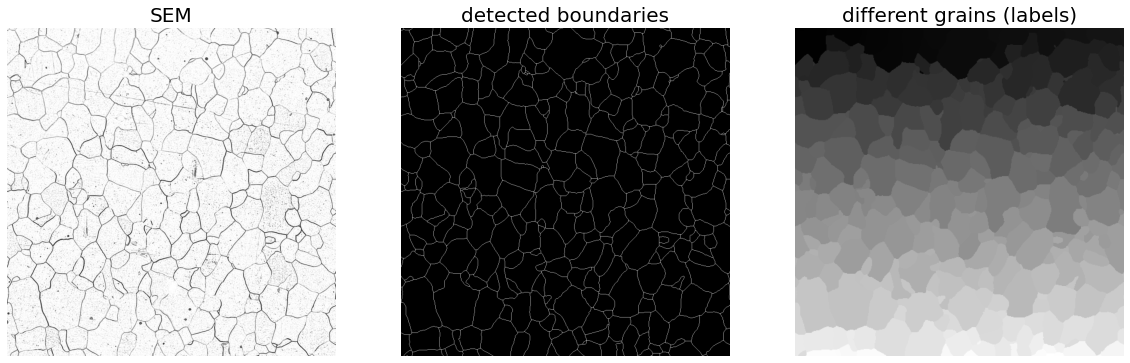

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(images[0],cmap='gray')
plt.axis('off')
plt.title("SEM", fontsize=20)
plt.subplot(132)
plt.imshow(boundaries[0],cmap='gray')
plt.axis('off')
plt.title("detected boundaries", fontsize=20)
plt.subplot(133)
plt.imshow(labels[0],cmap='gray')
plt.axis('off')
plt.title("different grains (labels)", fontsize=20)
plt.show()

In [ ]:
class SEM_Dataset(Dataset):
    def __init__(self, images, labels, boundaries):
        self.images = [torch.Tensor(i) for i in images]
        self.boundaries = [torch.Tensor(i) for i in boundaries]
        self.labels = [torch.Tensor(i) for i in labels]
        self.transform = Compose([RandomRotation(degrees=(-179, 179)),
                                  #RandomGrayscale()
                                 ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image=self.images[idx]
        image=image.reshape(-1,image.shape[0],image.shape[1])
        #image=self.transform(image)
        boundary=self.boundaries[idx]
        label=self.labels[idx]
        return image, boundary, label
    
SEM_images = SEM_Dataset(images, boundaries, labels)

torch.Size([2, 1, 1024, 1024]) torch.Size([2, 1024, 1024]) torch.Size([2, 1024, 1024])


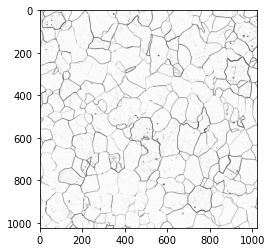

In [ ]:
batch_size=2
train_loader=DataLoader(dataset=SEM_images, batch_size=batch_size, shuffle=True)
for i, (img, bnd, lbl) in enumerate(train_loader):
    print(img.shape, bnd.shape, lbl.shape)
    plt.imshow(img[0][0],cmap='gray')
    break

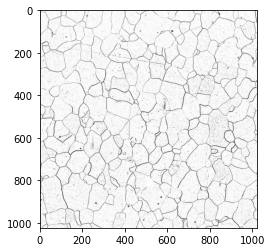

In [ ]:
plt.imshow(images[0],cmap='gray')
#[plt.imsave(f'Im_Iron/Im_{i}.jpeg', images[i],cmap='gray') for i in range(len(images))]
print()

### Mini Test Dataset

In [ ]:
img_0=np.asarray(Image.open('/Users/Nikolay/Desktop/SEM_Dataset/K06_SPS_2.5k_151.tif'))
img_1=np.asarray(Image.open('/Users/Nikolay/Desktop/Im_Iron/Im_0.jpeg'))
img_2=np.asarray(Image.open('/Users/Nikolay/Desktop/Im_Iron/Im_1.jpeg'))
image_list=[img_0, img_1, img_2]

for i,_ in enumerate(image_list):
    image_list[i]=image_list[i].transpose(2,0,1)
image_list[0]=image_list[0][:3,:,:]
print(image_list[0].shape,image_list[1].shape,image_list[2].shape)

mean_list=[]
disp_list=[]

(3, 672, 1024) (3, 1024, 1024) (3, 1024, 1024)


In [ ]:
class Artificial_Dataset(Dataset):
    def __init__(self, image_list, mean_list, disp_list):
        self.images = image_list
        self.means = mean_list
        self.dispersions = disp_list

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image=self.images[idx]
        image=image.reshape(-1,image.shape[0],image.shape[1])
        mean=self.boundaries[idx]
        disp=self.dispersions[idx]
        return image, boundary, label
    
AD_images = Artificial_Dataset(image, mean, disp)
batch_size=1
train_loader=DataLoader(dataset=AD_images, batch_size=batch_size, shuffle=True)

### CNN block

In [ ]:
class SEM(nn.Module):
    def __init__(self):
        super().__init__()
        
    def get_simple_block(self, input_dim, kernel_size=4, stride=2, padding=1, last_layer=False):
        if not last_layer:
            return nn.Sequential(
                nn.Conv2d(input_dim, 
                          input_dim*2,
                          kernel_size,
                          stride,
                          padding=padding),
                nn.BatchNorm2d(input_dim*2),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Conv2d(input_dim, 
                          input_dim*2,
                          kernel_size,
                          stride,
                          padding=padding)
    
    def CNN_block(self, input_dim, kernel_size=4, stride=2, padding=1):
        return nn.Sequential(self.get_simple_block(input_dim, kernel_size, stride, padding),
                             self.get_simple_block(input_dim*2, kernel_size, stride, padding),
                             self.get_simple_block(input_dim*4, kernel_size, stride, padding,last_layer=True))
    
    def linear_block(self, input_dim):
        return nn.Sequential(nn.Linear(input_dim,100),
                     nn.ReLU(),
                     nn.Linear(100,10),
                     nn.ReLU(),
                     nn.Linear(10,2))
    
    def forward(self,x):
        block=self.CNN_block(x.shape[1], kernel_size=4, stride=2, padding=1)
        x=block(x)
        x=torch.flatten(x, 1)
        lin_block=self.linear_block(x.shape[1])
        x=lin_block(x)
        return x


net=SEM()
print(net)#.parameters()

SEM()


### Train block

In [ ]:
learning_rate=0.01
def criterion(return_mean, true_mean, return_disp, true_disp):
    return torch.Tensor((true_mean-return_mean)**2+(true_disp-return_disp)**2)
optimizer=torch.optim.SGD(net.parameters(), lr=learning_rate)

ValueError: optimizer got an empty parameter list

In [ ]:
!

In [ ]:
def train(model=net, criterion, optimizer=optimizer, num_epochs=2):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        running_loss = 0.0
        running_corrects = 0
        for _, (image, mean, disp) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs[0], mean, outputs[1], disp)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Best val Acc: {best_acc:4f}')
    return